In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
import torch
from torch.autograd import grad
import torch.nn.functional as F
import torch.nn as nn

In [3]:
torch.manual_seed(42)

In [4]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 9.28MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 253kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.95MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.5MB/s]


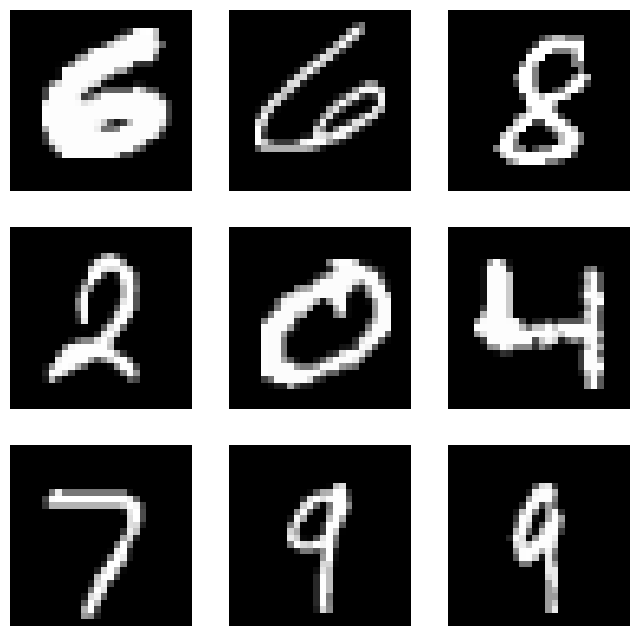

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
img, label =training_data[0]

In [8]:
img.shape


torch.Size([1, 28, 28])

In [19]:
def build_AlexNET():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
        
    net = torch.nn.Sequential(
        torch.nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2), 
        
        torch.nn.Conv2d(64, 192, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2), 
        
        torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        
        torch.nn.Flatten(),
        torch.nn.Linear(256*3*3, 4000),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(4000, 4000),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(4000, 10)
    )

    net.apply(init_weights)
    return net
alexnet = build_AlexNET()
print(alexnet)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=2304, out_features=4000, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=4000, out_features=4000, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.5, inplace=False)
  (20): Linear(in_feature

In [ ]:
net.__type_params__

()

In [15]:
train_dataloader= torch.utils.data.DataLoader(
    training_data, batch_size=512, shuffle =True, num_workers=8)
test_dataloader =torch.utils.data.DataLoader(
    test_data,batch_size=512,shuffle=False,num_workers=8)


In [16]:
from torch import optim
from tqdm import tqdm

In [ ]:
# define a train function, model-agnostic, which will be used for further training
def train(net, train_loader, device, num_epochs, learning_rate):
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                # Possibly copy inputs and labels to the GPU
                # batch x [48, 48, 1] -> batch x [1, 48, 48]
                inputs = inputs.permute(0, 1, 3,2).to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # Forward pass
                outputs = net(inputs)
                loss = loss_function(outputs, labels)

                # Backpropagation                
                loss.backward()

                # Update
                optimizer.step()

                # Print progress
                running_loss += loss.item()

                # Calculate batch Accuracy
                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            # Print the evaluation metric and reset it for the next epoch
            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history


In [22]:
# prepare training
BATCH_SIZE = 512
EPOCHS = 20
LR = 0.001
device='cpu'
net=alexnet

hist = train(net, train_dataloader, device, EPOCHS, LR)

Epoch: 19, Batch: 117, Loss: 8.68, Acc: 0.98: 100%|██████████| 2360/2360 [26:09<00:00,  1.50it/s] 


In [23]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

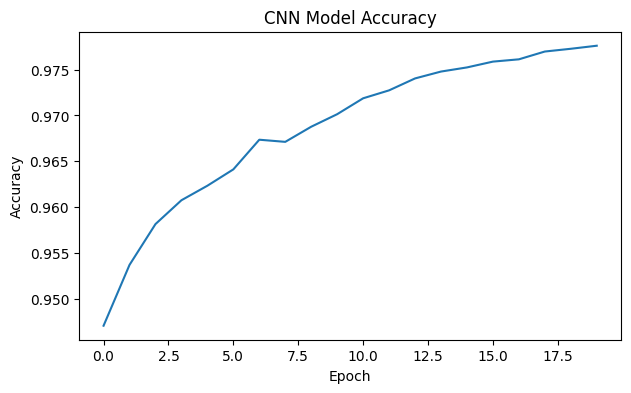

In [24]:
print_history(hist, "СNN Model Accuracy")

In [30]:
def evaluate_acc(net, test_loader, device='cpu'):

    total = 0
    correct = 0
    
    for batch_num, (inputs, labels) in enumerate(test_loader):
        # Possibly copy inputs and labels to the GPU
        inputs = inputs.permute(0, 1, 3,2).to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)        
        _, predicted = outputs.max(1)
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    acc = correct/total
    return acc


In [31]:
acc=evaluate_acc(alexnet,test_dataloader)

In [32]:
acc


0.9809